<a href="https://colab.research.google.com/github/mirianfsilva/The-Heat-Diffusion-Equation/blob/master/FiniteDiff_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementation of schemes for the Heat Equation:
- Forward Time, Centered Space;
- Backward Time, Centered Space;
- Crank-Nicolson.


\begin{equation}
    \partial_{t}u = \partial^2_{x}u , \quad 0 < x < 1, \quad t > 0 \\
\end{equation}
\begin{equation}
    \partial_{x}u(0,t) = 0, \quad \partial_x{u}(1,t) = 0\\
\end{equation}
\begin{equation}
    u(x, 0) = cos(\pi x)
\end{equation}

### Exact Solution: 
\begin{equation}
    u(x,t) = e^{-\pi^2t}cos(\pi x)
\end{equation}

In [0]:
#Numerical Differential Equations - Federal University of Minas Gerais
""" Utils """
import math, sys 
import numpy as np
import sympy as sp
from scipy import sparse
from sympy import fourier_series, pi
from scipy.fftpack import *
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from os import path
count = 0

In [0]:
#Heat Diffusion in one dimensional wire within the Explicit Method
"""
λ = 2, λ = 1/2 e λ = 1/6
M = 4, M = 8, M = 10, M = 12 e M = 14
"""    
#Heat function exact solution
def Solution(x, t):
    return np.exp((-np.pi**2)*t)*np.cos(np.pi*x)

In [0]:
# ---- Surface plot ----
def surfaceplot(U, Uexact, tspan, xspan, M): 
    N = M**2
    #meshgrid : Return coordinate matrices from coordinate vectors
    X, T = np.meshgrid(tspan, xspan)
    
    fig = plt.figure(figsize=plt.figaspect(0.3))
    #fig2 = plt.figure(figsize=plt.figaspect(0.5))
    #fig3 = plt.figure(figsize=plt.figaspect(0.5))
    
    # ---- Exact Solution ----
    ax = fig.add_subplot(1, 4, 1,projection='3d')
    surf = ax.plot_surface(X, T, Uexact, linewidth=0, cmap=cm.jet, antialiased=True)
    ax.set_title('Exact Solution')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')
    ax.set_zlabel('U')
    
    # ---- Method Aproximation Solution ----
    ax1 = fig.add_subplot(1, 4, 2,projection='3d')
    surf = ax1.plot_surface(X, T, U, linewidth=0, cmap=cm.jet, antialiased=True)
    ax1.set_title('Approximation')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Space')
    ax1.set_zlabel('U')
    
    plt.tight_layout()
    ax.view_init(30,230)
    ax1.view_init(30,230)
    
    fig.savefig(path.join("plot_METHOD{0}.png".format(count)),dpi=600)
    plt.draw()
    

In [0]:
'''
Exact Solution for 1D reaction-diffusion equation:
        u_t = k * u_xx
    
with Neumann boundary conditions 
at x=0: u_x(0,t) = 0
at x=L: u_x(L,t) = 0

with L = 1 and initial conditions:
u(x,0) = np.cos(np.pi*x)
'''

def ExactSolution(M, T = 0.5, L = 1):
    N = (M**2) #GRID POINTS on time interval

    xspan = np.linspace(0, L, M)
    tspan = np.linspace(0, T, N)
    
    Uexact = np.zeros((M, N))
    
    for i in range(0, M):
        for j in range(0, N):
            Uexact[i][j] = Solution(xspan[i], tspan[j])
    
    return (Uexact, tspan, xspan)

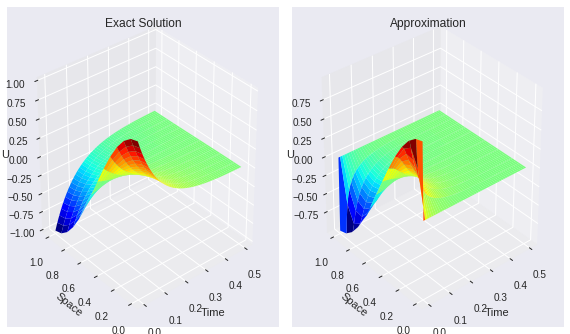

In [7]:
'''
Forward method to solve 1D reaction-diffusion equation:
        u_t = k * u_xx
    
with Neumann boundary conditions 
at x=0: u_x(0,t) = 0 = sin(2*np.pi)
at x=L: u_x(L,t) = 0 = sin(2*np.pi)

with L = 1 and initial conditions:
u(x,0) = (1.0/2.0)+ np.cos(2.0*np.pi*x) - (1.0/2.0)*np.cos(3*np.pi*x)

u_x(x,t) = (-4.0*(np.pi**2))np.exp(-4.0*(np.pi**2)*t)*np.cos(2.0*np.pi*x) + 
            (9.0/2.0)*(np.pi**2)*np.exp(-9.0*(np.pi**2)*t)*np.cos(3*np.pi*x))
'''

def ForwardEuler(M, lambd, T = 0.5, L = 1, k = 1): 
    #Parameters needed to solve the equation within the explicit method
    #M = GRID POINTS on space interval
    N = (M**2) #GRID POINTS on time interval

    # ---- Length of the wire in x direction ---- 
    x0 = 0
    xL = L

    # ----- Spatial discretization step -----
    dx = (xL - x0)/(M-1)

    # ---- Final time ---- 
    t0 = 0
    tF = T 

    # ----- Time step -----
    dt = (tF - t0)/(N-1)

    #lambd = dt*k/dx**2
    
    # ----- Creates grids -----
    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    # ----- Initializes matrix solution U -----
    U = np.zeros((M, N))

    # ----- Initial condition -----
    U[:,0] = np.cos(np.pi*xspan)

    # ----- Neumann boundary conditions -----
    """
    To implement these boundary conditions, we again use “false points”, x_0 and x_N+1 which are external points. 
    We use a difference to approximate ∂u/∂x (xL,t) and set it equal to the desired boundary condition:
    """
    
    f = np.arange(1, N+1)
    f = (-3*U[0,:] + 4*U[1,:] - U[2,:])/2*dx
    U[0,:] = (4*U[1,:] - U[2,:])/3
    
    g = np.arange(1, N+1)
    g = (-3*U[-1,:] + 4*U[-2,:] - U[-3,:])/2*dx
    U[-1,:] = (4*U[-2,:] - U[-3,:])/3
    
    # -----  ftcs -----
    for k in range(0, N-1):
        for i in range(1, M-1):
            U[i, k+1] = lambd*U[i-1, k] + (1-2*lambd)*U[i,k] + lambd*U[i+1,k] 
    
    return (U, tspan, xspan)

U, tspan, xspan = ForwardEuler(M = 14, lambd = 1.0/6.0)
Uexact, x, t = ExactSolution(M = 14)
surfaceplot(U, Uexact, tspan, xspan, M = 14)